In [29]:
import gymnasium as gym
from gymnasium import spaces
import hockey.hockey_env as h_env
import numpy as np
import itertools
import time
import torch
import pylab as plt
# %matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import memory as mem   
from feedforward import Feedforward

## Helper Functions

In [30]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [31]:
class DiscreteActionWrapper(gym.ActionWrapper):
    def __init__(self, env: gym.Env, bins = 8):
        """A wrapper for converting a 1D continuous actions into discrete ones.
        Args:
            env: The environment to apply the wrapper
            bins: number of discrete actions
        """
        assert isinstance(env.action_space, spaces.Box)
        super().__init__(env)
        self.bins = bins
        self.orig_action_space = env.action_space
        self.action_space = spaces.Discrete(self.bins)
        
    def action(self, action):
        """ discrete actions from low to high in 'bins'
        Args:
            action: The discrete action
        Returns:
            continuous action
        """
        return self.env.discrete_to_continous_action(action)

# DQN and RND

In [32]:
class QFunction(Feedforward):
    def __init__(self, observation_dim, action_dim, hidden_sizes=[100,100], 
                 learning_rate = 0.0002):
        super().__init__(input_size=observation_dim, hidden_sizes=hidden_sizes, 
                         output_size=action_dim)
        self.optimizer=torch.optim.Adam(self.parameters(), 
                                        lr=learning_rate, 
                                        eps=0.000001)
        self.loss = torch.nn.SmoothL1Loss() # MSELoss()
    
    def fit(self, observations, actions, targets):
        self.train() # put model in training mode
        self.optimizer.zero_grad()
        # Forward pass
        acts = torch.from_numpy(actions)
        pred = self.Q_value(torch.from_numpy(observations).float(), acts)
        # Compute Loss
        loss = self.loss(pred, torch.from_numpy(targets).float())
        
        # Backward pass
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def Q_value(self, observations, actions):
        return self.forward(observations).gather(1, actions[:,None])        
    
    def maxQ(self, observations):
        return np.max(self.predict(observations), axis=-1, keepdims=True)
        
    def greedyAction(self, observations):
        return np.argmax(self.predict(observations), axis=-1)
        

class RND():
    def __init__(self, input_dim, output_dim, hidden_dim=[100,100],
                 learning_rate = 0.0001):
        self.target = Feedforward(input_size = input_dim, hidden_sizes=hidden_dim, 
                                  output_size = output_dim)
        self.predictor = Feedforward(input_size = input_dim, hidden_sizes=hidden_dim, 
                                  output_size = output_dim)
        self.optimizer=torch.optim.Adam(self.predictor.parameters(), 
                                        lr=learning_rate, 
                                        eps=0.000001)
        self.loss = torch.nn.MSELoss()

    def intrinsic_reward(self, observations):
        output_target = self.target(observations).detach()
        output_prediction = self.predictor(observations)
        reward = self.loss(output_target, output_prediction)
        return reward

    def update_pred(self, reward):
        reward.backward()
        self.optimizer.step()
        

In [33]:
class DQNAgent(object):
    """
    Agent implementing Q-learning with NN function approximation.    
    """
    def __init__(self, observation_space, action_space, **userconfig):
        
        if not isinstance(observation_space, spaces.box.Box):
            raise UnsupportedSpace('Observation space {} incompatible ' \
                                   'with {}. (Require: Box)'.format(observation_space, self))
        if not isinstance(action_space, spaces.discrete.Discrete):
            raise UnsupportedSpace('Action space {} incompatible with {}.' \
                                   ' (Reqire Discrete.)'.format(action_space, self))
        
        self._observation_space = observation_space
        self._action_space = action_space
        self._action_n = action_space.n
        self._config = {
            "eps": 0.05,            # Epsilon in epsilon greedy policies                        
            "discount": 0.95,
            "buffer_size": int(1e5),
            "batch_size": 128,
            "learning_rate": 0.0002,
            "update_target_every": 20,
            "use_target_net":True
        }
        self._config.update(userconfig)        
        self._eps = self._config['eps']
        
        self.buffer = mem.Memory(max_size=self._config["buffer_size"])
                
        # Q Network
        self.Q = QFunction(observation_dim=self._observation_space.shape[0], 
                           action_dim=self._action_n,
                           learning_rate = self._config["learning_rate"])
        # Q Network
        self.Q_target = QFunction(observation_dim=self._observation_space.shape[0], 
                                  action_dim=self._action_n,
                                  learning_rate = 0)
        self._update_target_net()
        self.train_iter = 0
            
    def _update_target_net(self):        
        self.Q_target.load_state_dict(self.Q.state_dict())

    def act(self, observation, eps=None):
        if eps is None:
            eps = self._eps
        # epsilon greedy
        if np.random.random() > eps:
            action = self.Q.greedyAction(observation)
        else: 
            action = self._action_space.sample()        
        return action
    
    def store_transition(self, transition):
        self.buffer.add_transition(transition)
            
    def train(self, iter_fit=32):
        losses = []
        self.train_iter+=1
        if self._config["use_target_net"] and self.train_iter % self._config["update_target_every"] == 0:
            self._update_target_net()                
        for i in range(iter_fit):

            # sample from the replay buffer
            data=self.buffer.sample(batch=self._config['batch_size'])
            s = np.stack(data[:,0]) # s_t
            a = np.stack(data[:,1]) # a_t
            rew = np.stack(data[:,2])[:,None] # rew  (batchsize,1)
            s_prime = np.stack(data[:,3]) # s_t+1
            done = np.stack(data[:,4])[:,None] # done signal  (batchsize,1)
            
            if self._config["use_target_net"]:
                v_prime = self.Q_target.maxQ(s_prime)
            else:
                v_prime = self.Q.maxQ(s_prime)
            # target
            gamma=self._config['discount']                                                
            td_target = rew + gamma * (1.0-done) * v_prime
            
            # optimize the lsq objective
            fit_loss = self.Q.fit(s, a, td_target)
            
            losses.append(fit_loss)
                
        return losses

In [34]:
# dqn and rnd agent
class DQNRNDAgent(object):
    """
    Agent implementing Q-learning with NN function approximation.    
    """
    def __init__(self, observation_space, action_space, **userconfig):
        
        if not isinstance(observation_space, spaces.box.Box):
            raise UnsupportedSpace('Observation space {} incompatible ' \
                                   'with {}. (Require: Box)'.format(observation_space, self))
        if not isinstance(action_space, spaces.discrete.Discrete):
            raise UnsupportedSpace('Action space {} incompatible with {}.' \
                                   ' (Reqire Discrete.)'.format(action_space, self))
        
        self._observation_space = observation_space
        self._action_space = action_space
        self._action_n = action_space.n
        self._config = {
            "eps": 0.05,            # Epsilon in epsilon greedy policies                        
            "discount": 0.95,
            "buffer_size": int(1e5),
            "batch_size": 128,
            "learning_rate": 0.0002,
            "learning_rate_rnd": 0.0001,
            "update_target_every": 20,
            "use_target_net":True
        }
        self._config.update(userconfig)        
        self._eps = self._config['eps']
        
        self.buffer = mem.Memory(max_size=self._config["buffer_size"])

        # RND
        self.rnd = RND(input_dim=self._observation_space.shape[0], 
                       output_dim=self._action_n,
                       learning_rate = self._config["learning_rate_rnd"])
                
        # Q Network
        self.Q = QFunction(observation_dim=self._observation_space.shape[0], 
                           action_dim=self._action_n,
                           learning_rate = self._config["learning_rate"])
        # Q Network
        self.Q_target = QFunction(observation_dim=self._observation_space.shape[0], 
                                  action_dim=self._action_n,
                                  learning_rate = 0)
        self._update_target_net()
        self.train_iter = 0
            
    def _update_target_net(self):        
        self.Q_target.load_state_dict(self.Q.state_dict())

    def act(self, observation, eps=None):
        if eps is None:
            eps = self._eps
        # epsilon greedy
        if np.random.random() > eps:
            action = self.Q.greedyAction(observation)
        else: 
            action = self._action_space.sample()        
        return action
    
    def store_transition(self, transition):
        self.buffer.add_transition(transition)
            
    def train(self, iter_fit=32):
        losses = []
        self.train_iter+=1
        if self._config["use_target_net"] and self.train_iter % self._config["update_target_every"] == 0:
            self._update_target_net()                
        for i in range(iter_fit):

            # sample from the replay buffer
            data=self.buffer.sample(batch=self._config['batch_size'])
            s = np.stack(data[:,0]) # s_t
            a = np.stack(data[:,1]) # a_t
            rew = np.stack(data[:,2])[:,None] # rew  (batchsize,1)
            s_prime = np.stack(data[:,3]) # s_t+1
            done = np.stack(data[:,4])[:,None] # done signal  (batchsize,1)

            # intrinsic reward
            rew_i = self.rnd.intrinsic_reward(torch.from_numpy(s))
            self.rnd.update_pred(rew_i)         
            
            if self._config["use_target_net"]:
                v_prime = self.Q_target.maxQ(s_prime)
            else:
                v_prime = self.Q.maxQ(s_prime)
            # target
            gamma=self._config['discount']                                                
            td_target = rew + gamma * (1.0-done) * v_prime
            
            # optimize the lsq objective
            fit_loss = self.Q.fit(s, a, td_target)
            
            losses.append(fit_loss)
                
        return losses

## Test in Env

In [35]:
# env_name = 'Pendulum-v1'
# env_name = 'CartPole-v0'

env = h_env.HockeyEnv()

if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,8)

ac_space = env.action_space
o_space = env.observation_space
print(ac_space)
print(o_space)
print(list(zip(env.observation_space.low, env.observation_space.high)))

Discrete(8)
Box(-inf, inf, (18,), float32)
[(np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf))]


### No RND

In [36]:
use_target = True
target_update = 20
q_agent = DQNAgent(o_space, ac_space, discount=0.95, eps=0.2, 
                   use_target_net=use_target, update_target_every= target_update)

In [37]:
ob,_info = env.reset()
q_agent.Q.predict(ob)

array([ 0.14167607,  0.09933835, -0.14037946, -0.07529169,  0.24861555,
       -0.12195701, -0.26693723, -0.1461787 ], dtype=float32)

Running some episodes

In [38]:
stats = []
losses = []

In [39]:
max_episodes=600
max_steps=500 
for i in range(max_episodes):
    # print("Starting a new episode")    
    total_reward = 0
    ob, _info = env.reset()
    for t in range(max_steps):
        done = False        
        a = q_agent.act(ob)
        a2 = 
        (ob_new, reward, done, trunc, _info) = env.step(a)
        total_reward+= reward
        q_agent.store_transition((ob, a, reward, ob_new, done))            
        ob=ob_new        
        if done: break    
    losses.extend(q_agent.train(32))
    stats.append([i,total_reward,t+1])    
    
    if ((i-1)%20==0):
        print("{}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))

TypeError: Expected tuple or list of length 2, got length 0

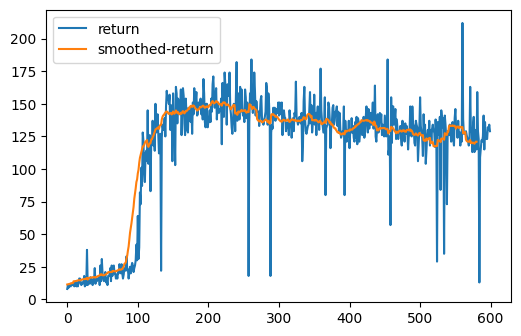

In [70]:
stats_np = np.asarray(stats)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

In [14]:
fig.savefig(f"DQN_{env_name}_training_w_target_{use_target}-update-{target_update}.pdf")

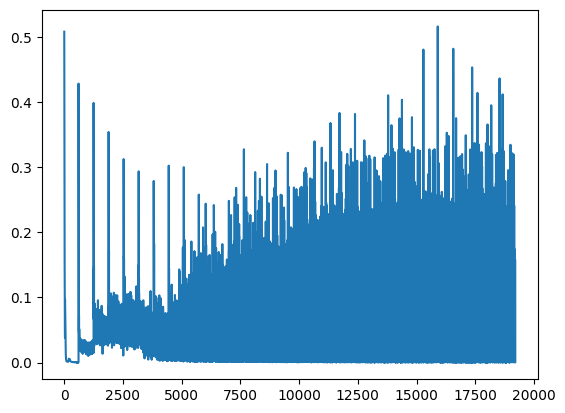

In [71]:
plt.figure()
plt.plot(losses_np)

In [16]:
# q_agent.train(1024)

In [17]:
q_agent.buffer.size

100000

### Using RND

In [72]:
use_target = True
target_update = 20
q_rnd_agent = DQNRNDAgent(o_space, ac_space, discount=0.95, eps=0.2, 
                   use_target_net=use_target, update_target_every= target_update)

In [73]:
stats = []
stats_intrinsic = []
losses = []

In [74]:
# with intrinsic rewards
max_episodes=600
max_steps=500 
for i in range(max_episodes):
    # print("Starting a new episode")    
    total_reward = 0
    total_intrinsic_reward = 0
    list_rew_i = []
    ob, _info = env.reset()
    for t in range(max_steps):
        done = False        
        a = q_rnd_agent.act(ob)
        (ob_new, reward, done, trunc, _info) = env.step(a)
        total_reward+= reward
        # get intrinsic rewards
        reward_i = q_rnd_agent.rnd.intrinsic_reward(torch.from_numpy(ob)).detach().item()
        list_rew_i.append(reward_i)
        
        # find combined reward
        if t==0:
            combined_reward = reward + reward_i
            total_intrinsic_reward+= reward_i
        elif t>0:
            # normalise intrinsic rewards by running std
            combined_reward = reward + (reward_i/np.std(list_rew_i))
            total_intrinsic_reward+= (reward_i/np.std(list_rew_i))
        q_rnd_agent.store_transition((ob, a, combined_reward, ob_new, done))            
        ob=ob_new        
        if done: break   
    losses.extend(q_rnd_agent.train(32))
    stats.append([i,total_reward,t+1])
    stats_intrinsic.append([i,total_intrinsic_reward,t+1])
    
    if ((i-1)%20==0):
        print("{}: Done after {} steps. Reward: {}. Intrinsic Reward: {}".format(
            i, t+1, total_reward, total_intrinsic_reward))

1: Done after 9 steps. Reward: 9.0. Intrinsic Reward: 22.509109142371223
21: Done after 24 steps. Reward: 24.0. Intrinsic Reward: 59.625870760336014
41: Done after 14 steps. Reward: 14.0. Intrinsic Reward: 34.25414892199508
61: Done after 8 steps. Reward: 8.0. Intrinsic Reward: 33.1810022915769
81: Done after 10 steps. Reward: 10.0. Intrinsic Reward: 30.10853034172228
101: Done after 10 steps. Reward: 10.0. Intrinsic Reward: 35.5719162614948
121: Done after 12 steps. Reward: 12.0. Intrinsic Reward: 36.505433249880696
141: Done after 12 steps. Reward: 12.0. Intrinsic Reward: 32.45933884220205
161: Done after 15 steps. Reward: 15.0. Intrinsic Reward: 54.5203445813424
181: Done after 16 steps. Reward: 16.0. Intrinsic Reward: 38.825210304390836
201: Done after 14 steps. Reward: 14.0. Intrinsic Reward: 40.77907367744449
221: Done after 14 steps. Reward: 14.0. Intrinsic Reward: 53.14164628839761
241: Done after 54 steps. Reward: 54.0. Intrinsic Reward: 80.56209593187569
261: Done after 111 s

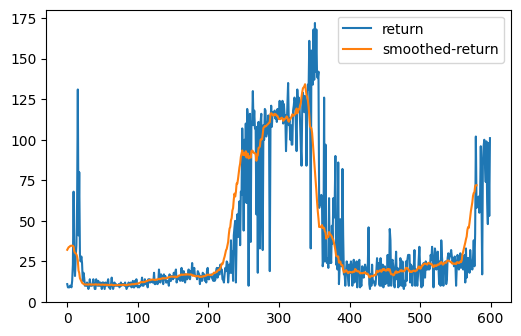

In [75]:
stats_np = np.asarray(stats)
stats_intrinsic_np = np.asarray(stats_intrinsic)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

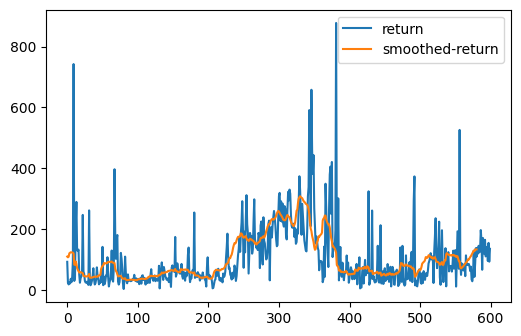

In [76]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_intrinsic_np[:,1], label="return")
plt.plot(running_mean(stats_intrinsic_np[:,1],20), label="smoothed-return")
plt.legend()

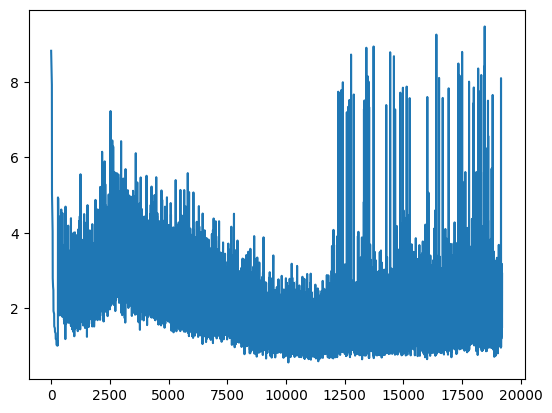

In [77]:
plt.figure()
losses_new = losses_np[np.where(losses_np<10)[0]]
plt.plot(losses_new)

## Evaluate (without exploration)

### Without RND

In [58]:
env_eval = gym.make(env_name, render_mode="human")
if isinstance(env.action_space, spaces.Box):
    env_eval = DiscreteActionWrapper(env_eval,5)

In [59]:
test_stats = []
episodes=50
env_ = env    # without rendering
#env_ = env_eval # with rendering

for i in range(episodes):
    total_reward = 0
    ob, _info = env_.reset()
    for t in range(max_steps):
        done = False        
        a = q_agent.act(ob, eps=0.0)
        (ob_new, reward, done, trunc, _info) = env_.step(a)
        total_reward+= reward
        ob=ob_new        
        if done: break    
    test_stats.append([i,total_reward,t+1])        

In [60]:
test_stats_np = np.array(test_stats)
print(np.mean(test_stats_np[:,1]), "+-", np.std(test_stats_np[:,1]))

-188.53472302529957 +- 134.42699461662252


### With RND

In [43]:
env_eval = gym.make(env_name, render_mode="human")
if isinstance(env.action_space, spaces.Box):
    env_eval = DiscreteActionWrapper(env_eval,5)

In [44]:
test_stats = []
episodes=50
env_ = env    # without rendering
#env_ = env_eval # with rendering

for i in range(episodes):
    total_reward = 0
    ob, _info = env_.reset()
    for t in range(max_steps):
        done = False        
        a = q_agent.act(ob, eps=0.0)
        (ob_new, reward, done, trunc, _info) = env_.step(a)
        total_reward+= reward
        ob=ob_new        
        if done: break    
    test_stats.append([i,total_reward,t+1])        

In [45]:
test_stats_np = np.array(test_stats)
print(np.mean(test_stats_np[:,1]), "+-", np.std(test_stats_np[:,1]))

-168.1429486612278 +- 115.80847486558686
